In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from datetime import datetime
from scipy.spatial.distance import pdist
from tqdm.notebook import tqdm, trange

import diffusion_maps
import lifter

subsample_training_data = False
if subsample_training_data:
    from subsample import subsample

In [2]:
plt.rc("axes",
    axisbelow = True,
    labelsize = 18,
    titlesize = 20
)
plt.rc("font", family = "serif")
plt.rc("image", cmap = "viridis")
plt.rc("legend",
    edgecolor = "k",
    fontsize = 15,
    framealpha = 1.0
)
plt.rc("text", usetex = True)
plt.rc("xtick", labelsize = 12)
plt.rc("ytick", labelsize = 12)

In [3]:
def rms_error(true_values, approximations, **kwargs):
    """
    Compute the root-mean-square error of a set of
    measurements, compared against true values.
    """
    return np.sqrt(np.mean((true_values - approximations)**2.0, **kwargs))

def rel_norm_error(true_values, approximations):
    error_norms = np.linalg.norm(true_values - approximations, axis = 1)
    truth_norms = np.linalg.norm(true_values, axis = 1)
    return np.sqrt(np.mean((error_norms/truth_norms)**2.0))

start_time = datetime.now()
print(start_time)

2022-08-02 11:17:33.557693


In [4]:
phi_idx = [1, 5, 11]
base_inputs = np.ones(4)
(q10, q12, q20, q21) = tuple(range(base_inputs.size))

limits = [
    (1.75, 2.25),
    (1.75, 2.25),
    (0.75, 1.25)
]

ticks = [
    np.linspace(1.8, 2.2, 3),
    np.linspace(1.8, 2.2, 3),
    np.linspace(0.8, 1.2, 3)
]

In [5]:
df_train = pd.read_excel("Simulation_and_DMaps.xlsx")
phi_train = df_train[["p%d" % i for i in phi_idx]].values
beta_train = df_train[[c for c in df_train.columns if c[0] == "b"]].values

In [6]:
df_test = pd.read_excel("Simulation_and_DMaps_Test_Data.xlsx")
phi_test = df_test[["p%d" % i for i in phi_idx]].values
beta_test = df_test[[c for c in df_test.columns if c[0] == "b"]].values

In [7]:
if subsample_training_data:
    (phi_train, idx) = subsample(phi_train, min_distance = 0.004, random_state = 77)
    beta_train = beta_train[idx]

# Forward Map: $\beta=h(\phi)$

In [8]:
pwsd = pdist(phi_train, "sqeuclidean")
forward_med_pwsd = np.median(pwsd)
print(forward_med_pwsd)

dmap_forward = diffusion_maps.SparseDiffusionMaps(
    points = phi_train,
    epsilon = 4.511e-03,
    num_eigenpairs = 200,
    cut_off = np.inf,
    renormalization = 0.0,
    normalize_kernel = False
)

0.0010126835633980063


In [9]:
forward_map = lifter.Lifter(phi_train, beta_train, dmap_forward)

forward_train_pred = forward_map(phi_train)
forward_train_RMSE = rms_error(beta_train, forward_train_pred, axis = 0)

forward_test_pred = forward_map(phi_test)
forward_test_RMSE = rms_error(beta_test, forward_test_pred, axis = 0)

forward_train_RNE = rel_norm_error(beta_train, forward_train_pred)
forward_test_RNE = rel_norm_error(beta_test, forward_test_pred)

print(
    "Training | RMSE: %8.2e, %8.2e, %8.2e | RNE: %8.2e\n    Test | RMSE: %8.2e, %8.2e, %8.2e | RNE: %8.2e" % \
    (*forward_train_RMSE, forward_train_RNE, *forward_test_RMSE, forward_test_RNE)
)

Training | RMSE: 1.10e-04, 5.26e-04, 4.02e-04 | RNE: 2.25e-04
    Test | RMSE: 1.87e-04, 9.44e-04, 7.04e-04 | RNE: 4.04e-04


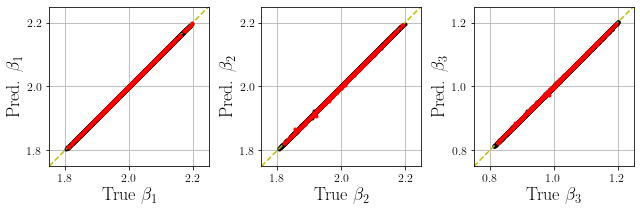

In [10]:
fig_01 = plt.figure(figsize = (9, 3))
for i in range(forward_train_pred.shape[1]):
    ax = fig_01.add_subplot(131 + i, aspect = "equal")
    ax.plot(beta_train[:,i], forward_train_pred[:,i], "k.", zorder = 1)
    ax.plot(beta_test[:,i], forward_test_pred[:,i], "r.", zorder = 3)
    ax.plot(limits[i], limits[i], "y--", zorder = 2)
    ax.set_xlim(limits[i])
    ax.set_ylim(limits[i])
    ax.set_xticks(ticks[i])
    ax.set_yticks(ticks[i])
    ax.set_xlabel(r"True $\beta_%d$" % (i+1,))
    ax.set_ylabel(r"Pred. $\beta_%d$" % (i+1,))
    ax.grid(True)
plt.tight_layout()

# Forward Jacobian

In [11]:
def jac_forward(x_new, determinant = False):
    """
    Compute, via the imported Lifter class, the Jacobian matrix
    (or determinant) for the geometric harmonics interpolation
    from DMaps coordinate to theoretical parameter values.
    """
    x_new = np.atleast_2d(x_new)
    if len(x_new.shape) > 2:
        raise ValueError("Input array must have two axes.")
    elif x_new.shape[1] != 3:
        raise ValueError("Input data must have three columns.")
    
    J = forward_map.jacobian(x_new)
    
    if determinant:
        return np.linalg.det(J)
    else:
        return J

forward_jacdets_train = jac_forward(phi_train, determinant = True)
forward_jacdets_test = jac_forward(phi_test, determinant = True)

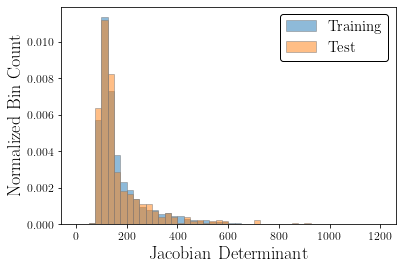

In [12]:
fig_02 = plt.figure(figsize = (6, 4))
ax = fig_02.add_subplot(111)
ax.hist(
    forward_jacdets_train,
    bins = np.linspace(0.0, 1.2e3, 49),
    edgecolor = "gray",
    label = "Training",
    alpha = 0.5,
    density = True
)
ax.hist(
    forward_jacdets_test,
    bins = np.linspace(0.0, 1.2e3, 49),
    edgecolor = "gray",
    label = "Test",
    alpha = 0.5,
    density = True
)
ax.set_xlabel("Jacobian Determinant")
ax.set_ylabel("Normalized Bin Count")
ax.legend()
ax.grid(False)

In [13]:
forward_scale = np.prod(np.std(phi_train, axis = 0)/np.std(beta_train, axis = 0))
print(forward_scale)

fig_02s = plt.figure(figsize = (6, 4))
ax = fig_02s.add_subplot(111)
ax.hist(
    forward_scale*forward_jacdets_train,
    bins = np.linspace(0.0, 7.0, 36),
    edgecolor = "gray",
    label = "Training",
    alpha = 0.5,
    density = True
)
ax.hist(
    forward_scale*forward_jacdets_test,
    bins = np.linspace(0.0, 7.0, 36),
    edgecolor = "gray",
    label = "Test",
    alpha = 0.5,
    density = True
)
ax.set_xlabel("Scaled Jacobian Determinant")
ax.set_ylabel("Normalized Bin Count")
ax.legend()
ax.grid(False)

0.005200192407679138


# Reverse Map: $\phi=h^{-1}(\beta)$

In [14]:
pwsd = pdist(beta_train, "sqeuclidean")
reverse_med_pwsd = np.median(pwsd)
print(reverse_med_pwsd)

dmap_reverse = diffusion_maps.SparseDiffusionMaps(
    points = beta_train,
    epsilon = 1.243e-01,
    num_eigenpairs = 200,
    cut_off = np.inf,
    renormalization = 0.0,
    normalize_kernel = False
)

0.030514783124089638


In [15]:
reverse_map = lifter.Lifter(beta_train, phi_train, dmap_reverse)

reverse_train_pred = reverse_map(beta_train)
reverse_train_RMSE = rms_error(phi_train, reverse_train_pred, axis = 0)

reverse_test_pred = reverse_map(beta_test)
reverse_test_RMSE = rms_error(phi_test, reverse_test_pred, axis = 0)

reverse_train_RNE = rel_norm_error(phi_train, reverse_train_pred)
reverse_test_RNE = rel_norm_error(phi_test, reverse_test_pred)

print(
    "Training | RMSE: %8.2e, %8.2e, %8.2e | RNE: %8.2e\n    Test | RMSE: %8.2e, %8.2e, %8.2e | RNE: %8.2e" % \
    (*reverse_train_RMSE, reverse_train_RNE, *reverse_test_RMSE, reverse_test_RNE)
)

Training | RMSE: 1.17e-06, 1.61e-05, 7.14e-05 | RNE: 4.06e-03
    Test | RMSE: 1.62e-06, 2.36e-05, 9.22e-05 | RNE: 4.79e-03


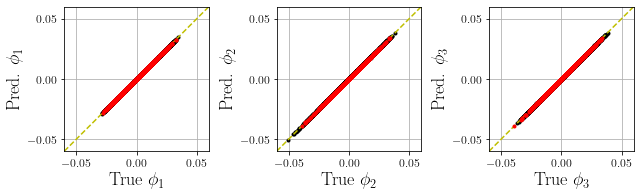

In [16]:
fig_03 = plt.figure(figsize = (9, 3))
for i in range(reverse_train_pred.shape[1]):
    ax = fig_03.add_subplot(131 + i, aspect = "equal")
    ax.plot(phi_train[:,i], reverse_train_pred[:,i], "k.", zorder = 1)
    ax.plot(phi_test[:,i], reverse_test_pred[:,i], "r.", zorder = 3)
    ax.plot([-0.06, 0.06], [-0.06, 0.06], "y--", zorder = 2)
    ax.set_xlim((-0.06, 0.06))
    ax.set_ylim((-0.06, 0.06))
    ax.set_xticks(np.linspace(-0.05, 0.05, 3))
    ax.set_yticks(np.linspace(-0.05, 0.05, 3))
    ax.set_xlabel(r"True $\phi_%d$" % (i+1,))
    ax.set_ylabel(r"Pred. $\phi_%d$" % (i+1,))
    ax.grid(True)
plt.tight_layout()

# Reverse Jacobian

In [17]:
def jac_reverse(x_new, determinant = False):
    """
    Compute, via the imported Lifter class, the Jacobian matrix
    (or determinant) for the geometric harmonics interpolation
    from DMaps coordinate to theoretical parameter values.
    """
    x_new = np.atleast_2d(x_new)
    if len(x_new.shape) > 2:
        raise ValueError("Input array must have two axes.")
    elif x_new.shape[1] != 3:
        raise ValueError("Input data must have three columns.")
    
    J = reverse_map.jacobian(x_new)
    
    if determinant:
        return np.linalg.det(J)
    else:
        return J

reverse_jacdets_train = jac_reverse(beta_train, determinant = True)
reverse_jacdets_test = jac_reverse(beta_test, determinant = True)

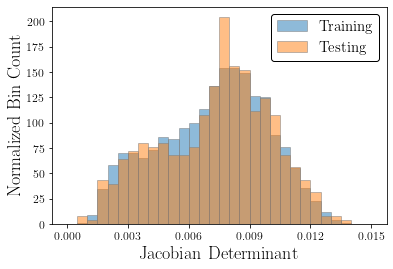

In [18]:
fig_04 = plt.figure(figsize = (6, 4))
ax = fig_04.add_subplot(111)
ax.hist(
    reverse_jacdets_train,
    np.linspace(0.0, 0.015, 31),
    edgecolor = "gray",
    label = "Training",
    alpha = 0.5,
    density = True
)
ax.hist(
    reverse_jacdets_test,
    bins = np.linspace(0.0, 0.015, 31),
    edgecolor = "gray",
    label = "Testing",
    alpha = 0.5,
    density = True
)
ax.set_xticks(np.linspace(0.0, 0.015, 6))
ax.set_xlabel("Jacobian Determinant")
ax.set_ylabel("Normalized Bin Count")
ax.legend()
ax.grid(False)

In [19]:
reverse_scale = np.prod(np.std(beta_train, axis = 0)/np.std(phi_train, axis = 0))
print(reverse_scale)

fig_04s = plt.figure(figsize = (6, 4))
ax = fig_04s.add_subplot(111)
ax.hist(
    reverse_scale*reverse_jacdets_train,
    bins = np.linspace(0.0, 3.0, 31),
    edgecolor = "gray",
    label = "Training",
    alpha = 0.5,
    density = True
)
ax.hist(
    reverse_scale*reverse_jacdets_test,
    bins = np.linspace(0.0, 3.0, 31),
    edgecolor = "gray",
    label = "Test",
    alpha = 0.5,
    density = True
)
ax.set_xlabel("Scaled Jacobian Determinant")
ax.set_ylabel("Normalized Bin Count")
ax.legend()
ax.grid(False)

192.3005769023656


In [20]:
train_summary = np.c_[
    beta_train,
    forward_train_pred,
    phi_train,
    reverse_train_pred,
    reverse_jacdets_train,
    forward_jacdets_train,
    np.zeros(phi_train.shape[0])
]

test_summary = np.c_[
    beta_test,
    forward_test_pred,
    phi_test,
    reverse_test_pred,
    reverse_jacdets_test,
    forward_jacdets_test,
    np.ones(phi_test.shape[0])
]

column_names = [("b%d" % (i+1,)) for i in range(beta_train.shape[1])] + \
               [("b%d_hat" % (i+1,)) for i in range(beta_train.shape[1])] + \
               [("p%d" % i) for i in phi_idx] + \
               [("p%d_hat" % i) for i in phi_idx] + \
               ["dJ_forward", "dJ_reverse", "is_test"]

df = pd.DataFrame(
    data = np.r_[train_summary, test_summary],
    columns = column_names
)
df.to_excel("Geometric_Harmonics.xlsx", index = False)

In [21]:
end_time = datetime.now()
print(end_time)
print(end_time - start_time)

2022-08-02 11:19:29.545559
0:01:55.987866
